In [29]:
from analyze_experiment_in_progress import get_data_from_logs
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from pathlib import Path
import gzip
sns.set()

In [2]:
#DATA_DIR=Path("./results/BERT4rec.ml-1m/ml1m_jpq_2023_02_10T18_42_52/")
DATA_DIR=Path('./results/gowalla_warm5/gowalla_benchmark_jpq_2023_02_10T17_45_31/')
data = get_data_from_logs(DATA_DIR/'stdout', 0)

In [3]:
import pandas as pd

In [4]:
df = pd.DataFrame(data)

In [5]:
df['type'] = df.model_name.apply(lambda x: x.split("-")[0])


In [6]:
df['embedding_size'] = df.model_name.apply(lambda x: int(x.split("-")[1].split(':')[1]))

In [7]:
df['pq_bytes'] =  df.model_name.apply( lambda x: int(x.split("-")[2].split(':')[1]) if len(x.split("-")) >=3 else None)

In [8]:
def get_model_size(model_name):
    file = DATA_DIR/'checkpoints'/(model_name + ".dill.gz")
    try:
        size = file.stat().st_size/(1024*1024) 
    except:
        size=None
    return size
    
df['compressed_checkpoint_file_size'] = df.model_name.apply(lambda x: get_model_size(x))

In [9]:
def get_uncompressed_size(model_name):
    file = DATA_DIR/'checkpoints'/(model_name + ".dill.gz")
    if not file.is_file():
        return None
    data = gzip.open(file).read()
    return len(data) / (1024*1024)
    
df['uncompressed_checkpoint_file_size'] = df.model_name.apply(lambda x: get_uncompressed_size(x))

In [10]:
df_rjpq = df[df.type == 'sasrjpq']

In [11]:
df_rjpq = df_rjpq.rename({"pq_bytes": "bytes_per_item"})
df_rjpq['bytes_per_item'] = df_rjpq['pq_bytes']
sas = df[df.type=='sas'].sort_values('embedding_size').fillna(0.0)
sas['bytes_per_item'] = sas['embedding_size'] * 4

/tmp/ipykernel_110776/2462670929.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  feature_map = df_rjpq.pivot("embedding_size", "pq_bytes", 'ndcg@10').fillna(0.0)


Text(153.75, 0.5, 'Embedding Size')

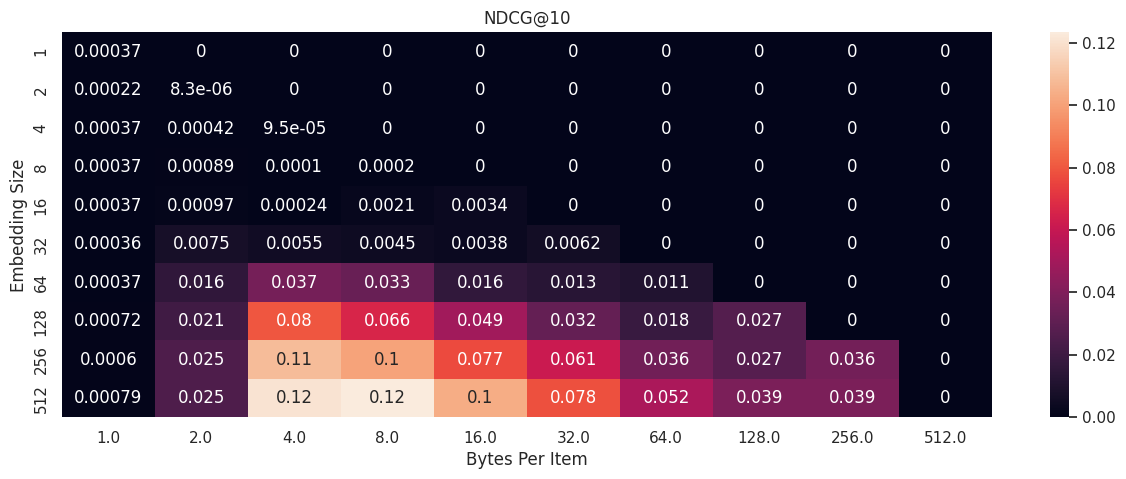

In [12]:
feature_map = df_rjpq.pivot("embedding_size", "pq_bytes", 'ndcg@10').fillna(0.0)
#del(feature_map[512.0])
plt.figure(figsize=(15,5))
sns.heatmap(feature_map, annot=True)
plt.title('NDCG@10')
plt.xlabel('Bytes Per Item')
plt.ylabel('Embedding Size')

/tmp/ipykernel_110776/1195676389.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  feature_map = df_rjpq.pivot("embedding_size", "pq_bytes", 'compressed_checkpoint_file_size').fillna(0.0)


Text(153.75, 0.5, 'Embedding Size')

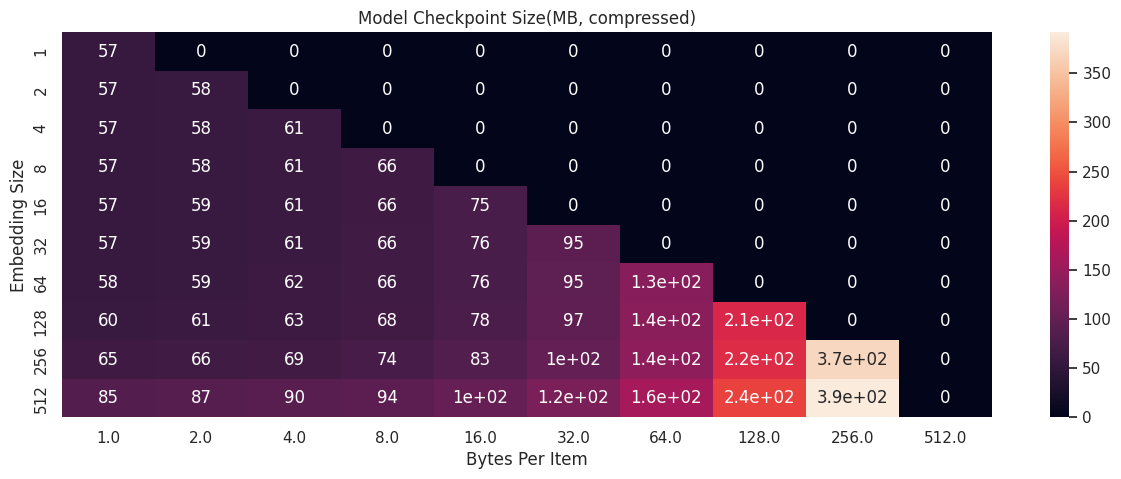

In [13]:
feature_map = df_rjpq.pivot("embedding_size", "pq_bytes", 'compressed_checkpoint_file_size').fillna(0.0)
#del(feature_map[512.0])
plt.figure(figsize=(15,5))
sns.heatmap(feature_map, annot=True)
plt.title('Model Checkpoint Size(MB, compressed)')
plt.xlabel('Bytes Per Item')
plt.ylabel('Embedding Size')

/tmp/ipykernel_110776/2624566720.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  feature_map = df_rjpq.pivot("embedding_size", "pq_bytes", 'uncompressed_checkpoint_file_size').fillna(0.0)


Text(153.75, 0.5, 'Embedding Size')

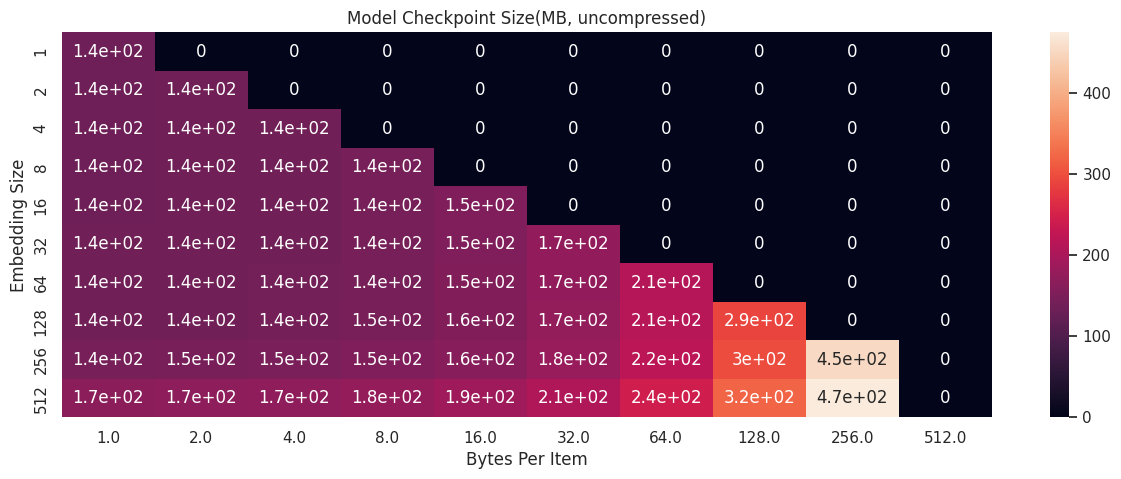

In [14]:
feature_map = df_rjpq.pivot("embedding_size", "pq_bytes", 'uncompressed_checkpoint_file_size').fillna(0.0)
#del(feature_map[512.0])
plt.figure(figsize=(15,5))
sns.heatmap(feature_map, annot=True)
plt.title('Model Checkpoint Size(MB, uncompressed)')
plt.xlabel('Bytes Per Item')
plt.ylabel('Embedding Size')

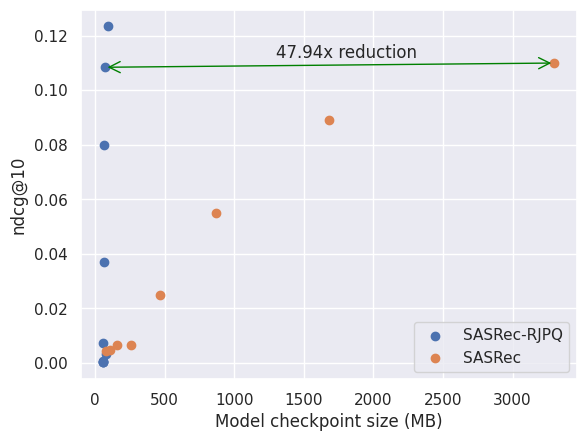

In [67]:
x =[]
y = []
min_y = 0.00

for i in range(0,10):
    p = 2**i
    df_emb = df_rjpq[df_rjpq['embedding_size'] == p].sort_values('ndcg@10', ascending=False)[:1].fillna(0.0)
    metric = list(df_emb['ndcg@10'])[0]
    if metric and  metric < min_y:
        continue
    x.append(list(df_emb['compressed_checkpoint_file_size'])[0])
    y.append(metric)
fig, ax = plt.subplots()

ax.scatter(x, y, label='SASRec-RJPQ',)


sas = sas.sort_values('uncompressed_checkpoint_file_size')
sas_filtered = sas[sas['ndcg@10']>=min_y].fillna(0.0)
sas_filtered

sas_x = sas_filtered['compressed_checkpoint_file_size']
sas_y = sas_filtered['ndcg@10']
ax.scatter(sas_filtered['compressed_checkpoint_file_size'], sas_filtered['ndcg@10'], label='SASRec')
#plt.xscale('log', base=10)
#plt.xlim(40, 2e4)
plt.ylabel('ndcg@10')
plt.xlabel('Model checkpoint size (MB)')
ax.legend()
compression = list(sas_x)[-1] / x[-2]

arrow = mpatches.FancyArrowPatch( (list(sas_x)[-1], list(sas_y)[-1]),(x[-2], y[-2]),
                                 mutation_scale=20, arrowstyle='<->', color='green')
ax.text(1300, 0.112, f"{compression:0.2f}x reduction")
ax.add_patch(arrow)

([68.79137229919434, 3298.1980209350586],
 [0.10838161029138355, 0.10993170511408193])

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

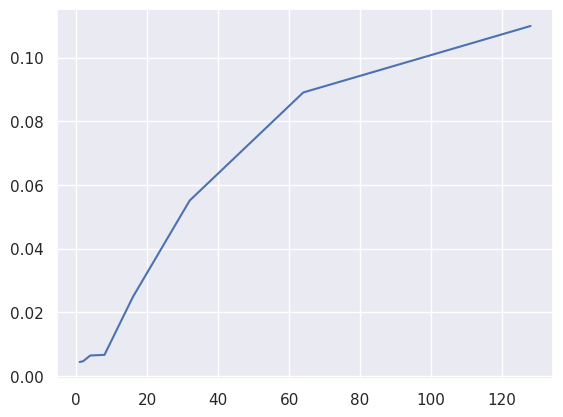

In [42]:
sas16 = df_rjpq[df_rjpq.pq_bytes==16].sort_values('embedding_size').fillna(0.0)
sas128 = df_rjpq[df_rjpq.pq_bytes==128].sort_values('embedding_size').fillna(0.0)


sns.lineplot(sas, x='embedding_size', y='ndcg@10', label='SASRec')
sns.lineplot(sas16, x='embedding_size', y='ndcg@10', label='SAS-RJPQ-b16' )
sns.lineplot(sas128, x='embedding_size', y='ndcg@10', label='SAS-RJPQ-b128' )
plt.xscale('log', base=2)

#### 

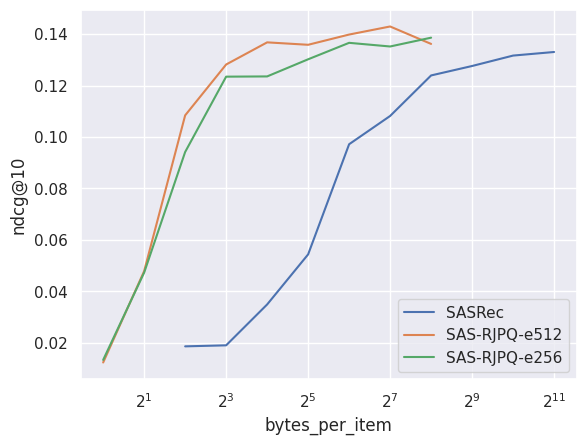

In [17]:
sas_e512 = df_rjpq[df_rjpq.embedding_size==512].sort_values('bytes_per_item')[:-1]
sas_e256 = df_rjpq[df_rjpq.embedding_size==256].sort_values('bytes_per_item')

sns.lineplot(sas, x='bytes_per_item', y='ndcg@10', label='SASRec')
sns.lineplot(sas_e512, x='bytes_per_item', y='ndcg@10', label='SAS-RJPQ-e512')
sns.lineplot(sas_e256, x='bytes_per_item', y='ndcg@10', label='SAS-RJPQ-e256')

plt.xscale('log', base=2)

In [80]:
import matplotlib as mpl
mpl.__version__

'3.6.2'

In [82]:
!pip3 install --upgrade matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 25.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.2
    Uninstalling matplotlib-3.6.2:
      Successfully uninstalled matplotlib-3.6.2
